## Import CIFAR10 - Object Recognition Data and Preprocessing




In [1]:
import tensorflow_hub as hub
import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.datasets import cifar10

## Import CIFAR10 - Object Recognition Datasets
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

## Split the datasets into training datasets, testing datasets and validation datasets
## Training datasets : 48000 image samples
## Validation datasets : 2000 image samples
## Testing datasets : 10000 image samples
x_val = x_train[-2000:,:,:,:]
x_train = x_train[:-2000,:,:,:]
y_val = y_train[-2000:]
y_train = y_train[:-2000]

# Apply one-hot encoding to the image label : Ex: Class '1' = [0,1,0,0,0,0,0,0,0,0,0]
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)
y_val   = tf.keras.utils.to_categorical(y_val)

## Ensure the shape of the x_train, x_val and x_test shape is meet the correct dimensions
print(f"x_train.shape :{x_train.shape}")
print(f"x_val.shape:{x_val.shape}")
print(f"x_test.shape:{x_test.shape}")


## Display warning if the dimensions are incorrect
assert(x_train.shape ==(48000,32,32,3)),"Incorrect x_train dimensions"
assert(x_val.shape ==(2000,32,32,3)),"Incorrect x_val dimensions"
assert(x_test.shape ==(10000,32,32,3)),"Incorrect x_test dimensions"

## Resize and Rescale : Resize first, then rescale
resize = tf.keras.layers.Resizing(224,224, interpolation="bilinear", crop_to_aspect_ratio=True,input_shape=x_train.shape[1:],name="Resizing_Layer")
rescale = tf.keras.layers.Rescaling(1./255)
                                    


x_train.shape :(48000, 32, 32, 3)
x_val.shape:(2000, 32, 32, 3)
x_test.shape:(10000, 32, 32, 3)


In [3]:
base_model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5",trainable=False)])
base_model.build([None, 224, 224, 3])  # Batch input shape.

## Create a Model 
input_layer = tf.keras.Input(shape=x_train.shape[1:]) ##Input 
x = resize(input_layer) ## Resize
x = rescale(x) ## Rescale
x = base_model(x) ## Feature extraction
x = tf.keras.layers.Flatten()(x) ## Flatten 
x = tf.keras.layers.Dense(10,activation="softmax")(x) ## Training classifier 
GoogLeNet_model = tf.keras.Model(inputs=input_layer, outputs=x) ## Input -> Input layer, Output -> Classifier
GoogLeNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 Resizing_Layer (Resizing)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 1024)              5607184   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 5,617,434
Trainable params: 10,250
Non-trainabl

## Data Augmentation

In [4]:
## Data Augmentation
## Rotating the image randomly by 10 degrees using the rotation_range parameter.
## Translating the image randomly horizontally or vertically by a 0.1 factor of the image's width or height using the width_shift_range and the height_shift_range parameters.
## Applying shear-based transformations randomly using the shear_range parameter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=10,  # rotation 10 degrees
                                   width_shift_range=0.1,  # horizontal shift
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip = True,
                                   fill_mode="nearest"
                                   )

train_datagen.fit(x_train)

## Training Model

In [5]:
logger = tf.keras.callbacks.TensorBoard( 
    log_dir=f'logs/GoogLeNet-TL-DA-CIFAR10',
    histogram_freq=5,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=True)


In [6]:
import numpy as np
batch_size=64
GoogLeNet_model.compile(loss="categorical_crossentropy",   # Loss function
                         optimizer='adam',        # Optimization technique
                         metrics=['accuracy'])

GoogLeNet_history = GoogLeNet_model.fit_generator(train_datagen.flow(x_train,y_train,batch_size=64), epochs = 10, shuffle=True,validation_data = (x_val,y_val),callbacks=[logger],steps_per_epoch=len(x_train)//batch_size,validation_steps=len(x_val)//batch_size)


C:\Users\jayan\AppData\Local\Temp\ipykernel_13912\2954515789.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  GoogLeNet_history = GoogLeNet_model.fit_generator(train_datagen.flow(x_train,y_train,batch_size=64), epochs = 10, shuffle=True,validation_data = (x_val,y_val),callbacks=[logger],steps_per_epoch=len(x_train)//batch_size,validation_steps=len(x_val)//batch_size)


Epoch 1/10
750/750 [==============================] - 1313s 2s/step - loss: 0.8029 - accuracy: 0.7327 - val_loss: 0.4631 - val_accuracy: 0.8415
Epoch 2/10
750/750 [==============================] - 1239s 2s/step - loss: 0.5937 - accuracy: 0.7957 - val_loss: 0.4208 - val_accuracy: 0.8545
Epoch 3/10
750/750 [==============================] - 1254s 2s/step - loss: 0.5548 - accuracy: 0.8066 - val_loss: 0.4090 - val_accuracy: 0.8625
Epoch 4/10
750/750 [==============================] - 1237s 2s/step - loss: 0.5381 - accuracy: 0.8131 - val_loss: 0.4067 - val_accuracy: 0.8580
Epoch 5/10
750/750 [==============================] - 1272s 2s/step - loss: 0.5242 - accuracy: 0.8154 - val_loss: 0.4071 - val_accuracy: 0.8610
Epoch 6/10
750/750 [==============================] - 1232s 2s/step - loss: 0.5115 - accuracy: 0.8209 - val_loss: 0.3938 - val_accuracy: 0.8690
Epoch 7/10
750/750 [==============================] - 1265s 2s/step - loss: 0.5062 - accuracy: 0.8235 - val_loss: 0.3956 - val_accuracy:

In [7]:
GoogLeNet_model.evaluate(x_test,y_test)

313/313 [==============================] - 249s 793ms/step - loss: 0.4014 - accuracy: 0.8562


[0.40141811966896057, 0.8561999797821045]

## Save Trained GoogleNet's Model and Weight

In [8]:
# Save ResNet50's trained weights (Filename : "ResNet50-TL-MNIST-weights.h5" )
GoogLeNet_model.save_weights("GoogLeNet-TL-DA-CIFAR10-weights.tf")

# Save ResNet50's trained model (Filename : "ResNet50-TL-MNIST-trained-model.h5")
GoogLeNet_model.save("GoogLeNet-TL-DA-CIFAR10-trained-model.tf")
print("GoogLeNet-TL-DA-CIFAR10-trained-model.h5 saved to disk.")

INFO:tensorflow:Assets written to: GoogLeNet-TL-DA-CIFAR10-trained-model.tf\assets


INFO:tensorflow:Assets written to: GoogLeNet-TL-DA-CIFAR10-trained-model.tf\assets


GoogLeNet-TL-DA-CIFAR10-trained-model.h5 saved to disk.


## Plot Training and Loss Curve ( Training vs Validation )

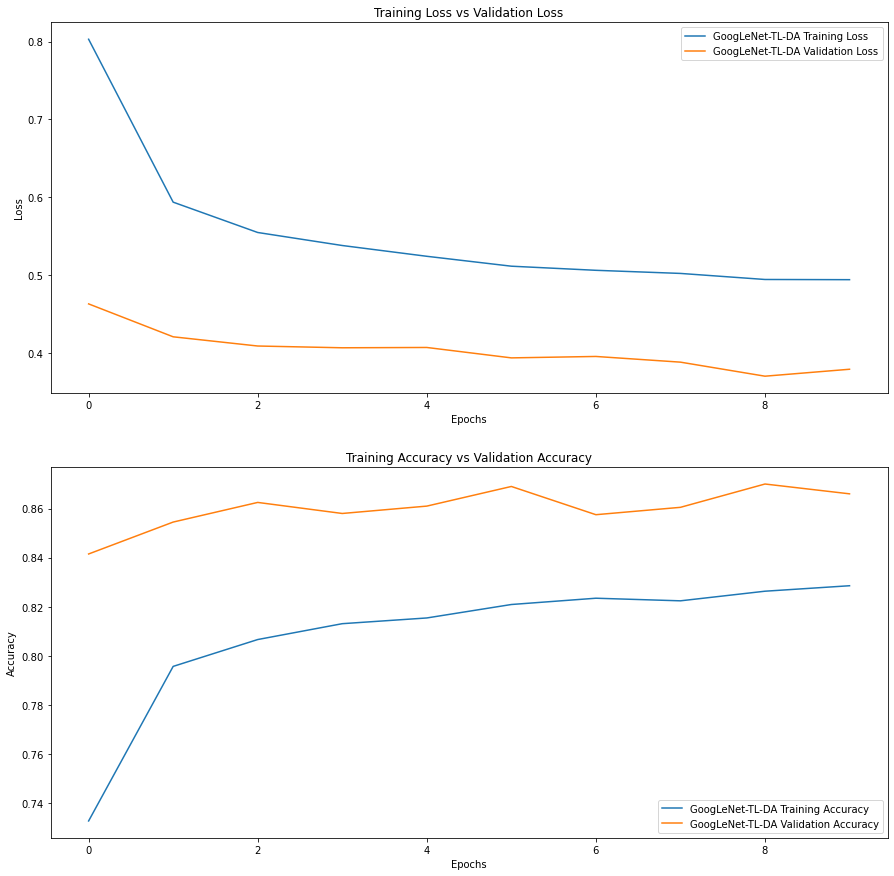

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(GoogLeNet_history.history['loss'])
axs[0].plot(GoogLeNet_history.history['val_loss'])

axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['GoogLeNet-TL-DA Training Loss', 'GoogLeNet-TL-DA Validation Loss'])

axs[1].plot(GoogLeNet_history.history['accuracy'])
axs[1].plot(GoogLeNet_history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['GoogLeNet-TL-DA Training Accuracy', 'GoogLeNet-TL-DA Validation Accuracy'])

## Model Evaluation: F1 score, Precision, Recall, Confusion Matrix

313/313 [==============================] - 235s 750ms/step
label precision recall F1
    0     0.919  0.847  0.881
    1     0.935  0.896  0.915
    2     0.760  0.871  0.812
    3     0.812  0.697  0.750
    4     0.879  0.732  0.799
    5     0.819  0.839  0.829
    6     0.824  0.906  0.863
    7     0.862  0.913  0.887
    8     0.919  0.914  0.916
    9     0.858  0.947  0.900
precision total: 0.8585767509404933
recall total: 0.8562
F1 total: 0.8552113965961503
Confusion matrix, without normalization
[[847  10  29   6   7   1   4  14  54  28]
 [  4 896   0   4   0   0   0   3   4  89]
 [ 14   0 871  11  29  17  38  17   2   1]
 [  3   1  60 697  16 118  66  23   3  13]
 [  7   1  99  23 732  12  63  59   4   0]
 [  3   0  23  80  13 839  16  23   2   1]
 [  5   0  34  22   9  17 906   3   1   3]
 [  3   1  21  10  20  21   4 913   3   4]
 [ 32  15   7   3   4   0   3   4 914  18]
 [  4  34   2   2   3   0   0   0   8 947]]
313/313 [==============================] - 240s 765ms/step

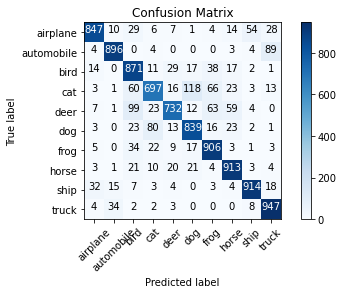

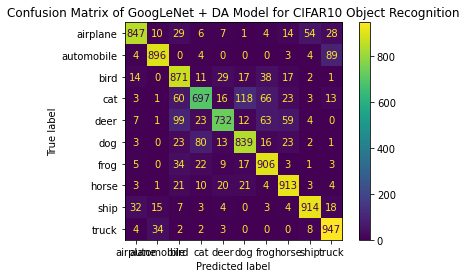

313/313 [==============================] - 241s 769ms/step


C:\Users\jayan\AppData\Local\Temp\ipykernel_13912\615024162.py:155: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


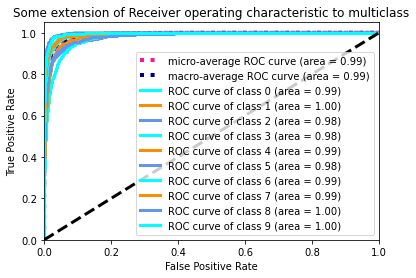

In [10]:
import itertools
from tensorflow.keras import layers, models,Input, Model
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, auc, roc_curve

## Load the Trained Model
CNN_model = models.load_model("GoogLeNet-TL-DA-CIFAR10-trained-model.tf")

## Make Prediction for the test datasets
predictions=CNN_model.predict(x_test)

## Convert from one-hot(2D) encoding to 1D
predictions=np.argmax(predictions, axis=1)
labels=np.argmax(y_test, axis=1)
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions)
confusion_matrix_original = confusion_matrix
confusion_matrix = confusion_matrix.numpy()

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return float(sum_of_precisions / rows)

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return float(sum_of_recalls / columns)

def F1(label,confusion_matrix):      
    F1=2*(precision(label,confusion_matrix)*(recall(label,confusion_matrix)))/(precision(label,confusion_matrix)+recall(label,confusion_matrix))
    return F1

print("label precision recall F1")
for label in range(10):
    print(f"{label:5d} {precision(label, confusion_matrix):9.3f} {recall(label, confusion_matrix):6.3f} {F1(label,confusion_matrix):6.3f}")

def F1_macro_average(confusion_matrix):
    rows,columns = confusion_matrix.shape
    sum_of_F1=0
    for label in range(rows):
        sum_of_F1+=F1(label,confusion_matrix)        
    return float(sum_of_F1/columns)

print("precision total:", precision_macro_average(confusion_matrix))

print("recall total:", recall_macro_average(confusion_matrix))

print("F1 total:", F1_macro_average(confusion_matrix))

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

cm_classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix of GoogLeNet+TL for CIFAR10 Object Recognition',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=confusion_matrix,classes=cm_classes,title="Confusion Matrix",cmap=plt.cm.Blues)

import sklearn
from sklearn import metrics
predictions=CNN_model.predict(x_test)

predictions=CNN_model.predict(x_test)
##predictions_list=[]
##predictions_list=[[1 if predictions[j][i]>0.5 else 0 for i in range(10)] for j in range(10000)]
predictions=np.argmax(predictions, axis=1)
labels=np.argmax(y_test, axis=1)
report = sklearn.metrics.classification_report(labels, predictions, digits=3)
print(report)

# Compute ROC curve and ROC area for each class
### roc_curve and auc is only support for one-hot encoding 
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=cm_classes)
disp.plot()
plt.title("Confusion Matrix of GoogLeNet + DA Model for CIFAR10 Object Recognition")
plt.show()

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
fpr = dict()
tpr = dict()
predictions=CNN_model.predict(x_test)
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i]
                                  , predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes=10
lw=3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()